In [1]:
import pandas as pd
import glob
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import statsmodels.stats.multitest as ss
from scipy import stats
import cartopy.feature as cfeature

Duplicate key in file PosixPath('/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.sans-serif: Arial')


In [2]:
def calc_rho_pval(summed_count_df, method = 'Bonferroni'):
    out_rho = pd.DataFrame(columns= summed_count_df.columns,index= summed_count_df.columns, )
    out_pval = pd.DataFrame(columns= summed_count_df.columns,index= summed_count_df.columns, )

    for j in summed_count_df.columns:
        for i in summed_count_df.columns:
            dd = summed_count_df[[i,j]].dropna()
            rho, pval =stats.spearmanr(dd[i], dd[j])
            if i==j:
                out_rho.loc[i, j] = 1
                out_pval.loc[i, j] = 0
            else:
                out_rho.loc[i, j] = rho;
                out_pval.loc[i,j] = pval;
#         out_rho.columns = test_corr_pval.columns
#         out_rho.index = test_corr_pval.columns
#         out_pval.columns = test_corr_pval.columns
#         out_pval.index = test_corr_pval.columns
#         out_bonfe=pd.DataFrame(columns = test_corr_pval.columns, index = test_corr_pval.columns)
#         out_bool=pd.DataFrame(columns = test_corr_pval.columns, index = test_corr_pval.columns)

#         for column in out_pval.columns:
#             a, b,c,d = ss.multipletests(out_pval[column], method='bonferroni')
#             out_bonfe[column] = b
#             out_bool[column] = a
    out_bonfe = pd.DataFrame(out_pval.unstack())
    a, b ,c, d = ss.multipletests(pd.DataFrame(out_pval.unstack())[0], method=method)
    out_bonfe[0]=b
    out_bonfe = out_bonfe.reset_index().pivot(columns='level_0', index='level_1', values=0)
    return(out_rho, out_pval, out_bonfe)

In [3]:
def cluster_map_bonfe(rhodf, pvaldf, figname='figures/cluster.pdf',
                      cutoff=0.05, col_colors=None, row_colors=None, symbol='*'):
    cluster = sns.clustermap(rhodf.fillna(0), col_colors=col_colors, row_colors=row_colors,yticklabels=1, 
                         metric='braycurtis',
                 vmin=-1, vmax=1, cmap=sns.color_palette("icefire", as_cmap=True),
                  xticklabels =1,)
    posx_dict={}
    for i in np.array(cluster.ax_heatmap.get_xticklabels()):
        posx_dict[i.get_text()] = i.get_position()[0]
    posy_dict={}
    for i in np.array(cluster.ax_heatmap.get_yticklabels()):
        posy_dict[i.get_text()] = i.get_position()[1]

    sig_map = pvaldf<cutoff
    sig_map.index = sig_map.index.map(posy_dict)
    sig_map.columns = sig_map.columns.map(posx_dict)
    x =[]
    y = []
    for i in sig_map.index:
        for c in sig_map.columns:
            if sig_map.loc[i,c]==True:
                x.append(c)
                y.append(i)
    ax = cluster.ax_heatmap
    ax.scatter(x,y, marker=symbol, color='white', s=2)

    plt.savefig(figname)
    


In [4]:
def cal_bonfe(out_pval, cols, index, method = 'bonferroni'):
    out_bonfe = pd.DataFrame(out_pval.unstack())
    a, b ,c, d = ss.multipletests(pd.DataFrame(out_pval.unstack())[0], method=method)
    out_bonfe[0]=b
    out_bonfe = out_bonfe.reset_index().pivot(columns='level_0', index='level_1', values=0)
    return(out_bonfe)

In [5]:
def get_all_genes_summed(dtype='Tbact'):
    dict_k = {}
    for k in subset_abund.keys():
        if 'taxonomy' in subset_abund[k][dtype]:
            kdf = pd.DataFrame(subset_abund[k][dtype].drop('taxonomy', axis=1).sum().sort_values())
            kdf.columns = [k]
            dict_k[k] = kdf
    bigd = pd.concat(dict_k, axis = 1)
    bigd.columns = bigd.columns.get_level_values(0)
    return(bigd)

def corr_data(Tbact_summed):
    Tbact_summed_corr = Tbact_summed.corr('pearson')
    type_mol = pd.DataFrame(ko_indexed.loc[Tbact_summed.corr().index].TYPE).reset_index().drop_duplicates().sort_values('ALLKO').replace('Sugar', 'Sugar alcohol').drop_duplicates().set_index('ALLKO')
    type_col = type_mol.to_dict()['TYPE']
    Tbact_summed_corr['TYPE'] = Tbact_summed_corr.index.map(type_col)
    network_pal = sns.light_palette('red', len(Tbact_summed_corr.TYPE.unique()))
    network_lut = dict(zip(Tbact_summed_corr.TYPE.unique(), network_pal))
    network_colors = pd.Series(Tbact_summed_corr.TYPE).map(network_lut)
    # Teuk_summed = get_all_genes_summed(dtype='Teuk')
#     sns.clustermap(Tbact_summed_corr.fillna(0)[Tbact_summed_corr.index], row_colors=network_colors)
    Tbact_summed_env = Tbact_summed.merge(env_params, left_index=True, right_index=True, how='left')
    Tbact_summed_env = Tbact_summed_env[~Tbact_summed_env.index.duplicated(keep='first')]
    return(Tbact_summed_corr, Tbact_summed_env)

In [6]:
def Kplot_maps_overlay(Tbact_summed_env, K='K00130', scale = 10e5):
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
        
    for depth, color in zip(['SRF', 'DCM', 'MES'], ['green', 'blue', 'red']):
        subset = Tbact_summed_env[Tbact_summed_env['depth']==depth]
        ax.scatter(x =subset.longitude, y=subset.latitude, 
               s= subset[K]*scale, transform=ccrs.PlateCarree(), alpha=0.5,color=color)
    plt.show()
    
def Kplot_maps_subplot(Tbact_summed_env, Klist=['K00130'], kname='test', scale = 10e5, color='blue', depth_list = ['SRF', 'DCM', 'MES']):
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(len(Klist), 3)
    for i, k in enumerate(Klist):
        for j,d in enumerate(depth_list):
            
            subset = Tbact_summed_env[Tbact_summed_env['depth']==d]
            
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
            ax.coastlines()
            ax.scatter(x =subset.longitude, y=subset.latitude, 
               s= subset[k]*scale, transform=ccrs.PlateCarree(), alpha=0.8,color=color)
            ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            if j == 0:
                ax.text(-350,1, k, fontsize=14)

            if i ==0:
                ax.set_title(d)

    plt.savefig(kname+'.pdf')
    return()


sns.set(rc={'figure.figsize':(20,10)})

def create_box_plot(Tbact_summed, compound = 'Glycine betaine', colors = ['#6E8A0F','#A1A1A1']):
    sns.set_style("white")
    Trans = Tbact_summed[bd_groups[(compound, 'TRANSPORT')]]
    Syn = Tbact_summed[Tbact_summed.columns.intersection(bd_groups[(compound, 'SYNTHESIS')])]
    BD = Tbact_summed[Tbact_summed.columns.intersection(bd_groups[(compound, 'BREAKDOWN')])]
    SynBD = Syn.merge(BD, left_index = True, right_index=True, how='inner')
    print(SynBD.columns)
    cdict = {}
    for t, c in zip([Trans, SynBD], colors):
        for k in t.columns:
            cdict[k]=c
    tt = Trans.merge(SynBD, left_index=True, right_index=True)
    g = sns.boxplot(data = tt,palette=cdict)
    g.set_yscale('log')
    return(tt, cdict)

# Read in data 

In [7]:
kcutoffs = pd.read_csv('../tara-scraping/ko_list', sep='\t', index_col=0)
llist = ['Teuk', 'Geuk', 'Tbact', 'Gbact']

ev_dict = {}
for ev in glob.glob('../tara-scraping/downloads/K00011/*/environmental_parameters.csv'):
    dd = pd.read_csv(ev, sep='\t', index_col='sample_ID')
    ev_dict[ev] = dd
env_params = pd.concat(ev_dict).reset_index().drop('level_0', axis=1).set_index('sample_ID')
env_params = env_params.drop_duplicates(keep='first')

In [8]:
aln_dict = {}
full_dict = {}
ndict  = {}
for lk in glob.glob('../tara-scraping/downloads/K*'):
    fdict = {}
    ndict = {} 
    k = os.path.basename(lk)
    cutoff = float(kcutoffs.loc[k, 'threshold'])
    for t in llist:
        f = os.path.join(lk, t, '_'.join([k, t, 'aln_result.tsv']))
        if os.stat(f).st_size == 0:
            ndict[t] = pd.DataFrame()
            pass
        else:
            df = pd.read_csv(f, skiprows=8, sep = '\t', index_col=1)
            if 'euk' in t:
                df.index = df.index.str.split("_").str[0:2].str.join('_')    
            passing_genes = df[df.bit_score>cutoff]
            ndict[t] = passing_genes.index
            fdict[t] = df.index
    aln_dict[k] = ndict
    full_dict[k] = fdict

In [9]:
# Read in all abundance files from ocean viewer
ndict = {}
abund_dict = {}
for lk in glob.glob('../tara-scraping/downloads/K*'):
    ndict = {}
    k = os.path.basename(lk)
    for t in llist:
        f = os.path.join(lk, t, 'abundance_matrix.csv')

        if os.stat(f).st_size == 0:
            ndict[t]=pd.DataFrame()
            pass
        else:
            df = pd.read_csv(f, sep ='\t', header = 0, skiprows=1, index_col=0)
            ndict[t]=df
    abund_dict[k] = ndict

In [10]:
# limit abundances to just those that are passing the hmm threshold

subset_abund = {}
for lk in glob.glob('../tara-scraping/downloads/K*'):
    k = os.path.basename(lk)
    ndict = {}
    for t in llist:
        
        subset = set(abund_dict[k][t].index).intersection(aln_dict[k][t])
        aa = abund_dict[k][t].loc[subset]
        ndict[t]=aa
    subset_abund[k]=ndict

In [11]:
total_counts = pd.DataFrame(index = full_dict.keys(), columns = ['MATOU_total', 'OM-RGC_total','MATOU_hmmpass', 'OM-RGC_hmmpass', ] )
for key in full_dict:
    for t in full_dict[key]:
        if 'euk' in t:
            euk = len(full_dict[key][t])
            euk_aln = len(aln_dict[key][t])
        else:
            bact = len(full_dict[key][t])
            bact_aln = len(aln_dict[key][t])
    total_counts.loc[key, 'MATOU_total']=euk
    total_counts.loc[key, 'OM-RGC_total']=bact
    total_counts.loc[key, 'MATOU_hmmpass']=euk_aln
    total_counts.loc[key, 'OM-RGC_hmmpass']=bact_aln

total_counts = total_counts.merge(kcutoffs[['threshold', 'alen', 'definition']], left_index=True, right_index=True, how='inner')

total_counts.to_csv('figures/tara/hmm_passing_counts.csv')
total_counts

,MATOU_total,OM-RGC_total,MATOU_hmmpass,OM-RGC_hmmpass,threshold,alen,definition
K00130,52672,69831,54,259,668.20,2518,betaine-aldehyde dehydrogenase [EC:1.2.1.8]
K17742,45896,154362,139,11,304.87,1299,sorbose reductase [EC:1.1.1.289]
K10227,123,1864,10,276,375.03,1488,sorbitol/mannitol transport system substrate-b...
K00008,20555,43624,469,12,388.50,3441,L-iditol 2-dehydrogenase [EC:1.1.1.14]
K00315,12017,58388,105,810,913.03,3052,dimethylglycine dehydrogenase [EC:1.5.8.4]
K08261,44855,152543,0,0,456.33,309,D-sorbitol dehydrogenase (acceptor) [EC:1.1.99...
K17755,7629,19487,0,0,816.17,641,choline oxidase [EC:1.1.3.17]
K00305,61,4856,11,544,132.53,622,"sarcosine oxidase, subunit gamma [EC:1.5.3.1]"
K00544,9705,7613,4267,1282,181.53,1223,betaine-homocysteine S-methyltransferase [EC:2...
K00011,37518,4645,158,0,535.23,1533,aldehyde reductase [EC:1.1.1.21]


In [12]:
df = pd.read_csv('../input/Osmolyte-Reactions.tsv', sep='\t')
df.ORTHOLOGY = df.ORTHOLOGY.str.split(';')
df = df[df['ORTHOLOGY'].notna()]
df['COMBINED_ORTHO'] = df[['NAMED_GROUP', 'PATHWAY']].astype(str).agg(':'.join, axis=1)
df['COMBINED_ORTHO_STEP'] = df[['NAMED_GROUP', 'PATHWAY', 'STEP']].astype(str).agg(':'.join, axis=1)
df['max_step']= df.groupby('COMBINED_ORTHO')['STEP'].transform('max')
df['ALLKO']=df.groupby('COMBINED_ORTHO_STEP')['ORTHOLOGY'].transform(sum)

#Subset the DF to just columns that we will be using
subset_df = df[['COMPOUND_NAME','COMPOUND','BROAD', 'NAMED_GROUP', 'COMBINED_ORTHO','COMBINED_ORTHO_STEP', 'ALLKO', 'max_step']]
subset_df = subset_df.loc[subset_df[['COMPOUND_NAME','COMPOUND','BROAD', 'NAMED_GROUP', 'COMBINED_ORTHO','COMBINED_ORTHO_STEP']].drop_duplicates().index]

metabolite_dict = pd.read_csv('../input/types.csv')[['metabolite', 'gentype']].set_index('metabolite').to_dict()['gentype']
#Index by KOs in an explosive fashion
ko_indexed = subset_df.explode('ALLKO').set_index('ALLKO')
ko_indexed['TYPE'] = ko_indexed.COMPOUND_NAME.map(metabolite_dict)
ko_indexed

,COMPOUND_NAME,COMPOUND,BROAD,NAMED_GROUP,COMBINED_ORTHO,COMBINED_ORTHO_STEP,max_step,TYPE
ALLKO,,,,,,,,
K00864,Glycerol,C00116,BREAKDOWN,Glycerol breakdown to sn-Glycerol 3-phosphate,Glycerol breakdown to sn-Glycerol 3-phosphate:1,Glycerol breakdown to sn-Glycerol 3-phosphate:1:1,1,Sugar alcohol
K00863,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
K05878,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
K05879,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
K05881,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
...,...,...,...,...,...,...,...,...
K10674,Ectoine,C06231,BREAKDOWN,Ectoine transformation to 5-Hydroxyectoine,Ectoine transformation to 5-Hydroxyectoine:1,Ectoine transformation to 5-Hydroxyectoine:1:1,1,Amino acid
K15783,Ectoine,C06231,BREAKDOWN,Ectoine recycling,Ectoine recycling:1,Ectoine recycling:1:1,3,Amino acid
K15784,Ectoine,C06231,BREAKDOWN,Ectoine recycling,Ectoine recycling:1,Ectoine recycling:1:2,3,Amino acid


# Get summed counts for different data types


In [13]:
# Bacterial

Tbact_summed = get_all_genes_summed()
Tbact_summed_corr, Tbact_summed_env = corr_data(Tbact_summed)
Gbact_summed = get_all_genes_summed(dtype='Gbact')
Gbact_summed_corr, Gbact_summed_env = corr_data(Gbact_summed)

#Eukaryotic 
Teuk_summed = get_all_genes_summed(dtype='Teuk')
Teuk_summed_corr, Teuk_summed_env = corr_data(Teuk_summed)
Geuk_summed = get_all_genes_summed(dtype='Geuk')
Geuk_summed_corr, Geuk_summed_env = corr_data(Geuk_summed)

In [14]:
compound_dict = {}
for g, n in ko_indexed.loc[Tbact_summed.columns].groupby('COMPOUND_NAME'):
    compound_dict[g]= sorted(list(set(n.index)))
    
for g, n in ko_indexed.loc[Tbact_summed.columns].groupby('COMPOUND_NAME'):
    compound_dict[g]= set(n.index)
bd_groups = {}
for group, df in ko_indexed.groupby(['COMPOUND_NAME', 'BROAD']):
    bd_groups[group]= sorted(list(set(df.index)))
    

# Focus on Glycine betaine and Mannitol related KOs

In [15]:
GBsets = [('Glycine betaine', 'BREAKDOWN'), ('Glycine betaine', 'SYNTHESIS'), ('Glycine betaine', 'TRANSPORT')]
Msets = [('Mannitol', 'BREAKDOWN'), ('Mannitol', 'SYNTHESIS'), ('Mannitol', 'TRANSPORT'),]

# Bacterial Figures

Index(['K00130', 'K17755', 'K00499', 'K14085', 'K18897', 'K24071', 'K18896',
       'K11440', 'K13042', 'K00108', 'K00315', 'K00305', 'K00544', 'K00314',
       'K00304', 'K00303', 'K00309', 'K00302', 'K00306', 'K00301'],
      dtype='object')


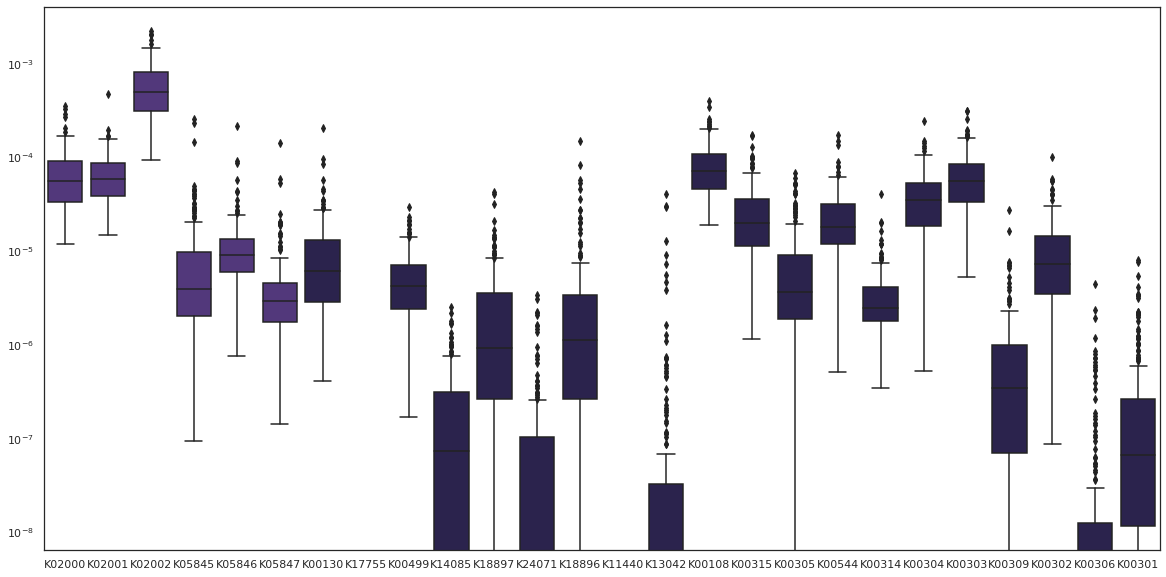

In [16]:
GB_combo, GB_cdict = create_box_plot(Tbact_summed, compound='Glycine betaine', colors  = ['#4F2D86','#271C54'])
plt.savefig('figures/tara/Bact_Glycine_betaine_distributions.pdf')

Index(['K00008', 'K19270_x', 'K00007_x', 'K24204_x', 'K00009_x', 'K00045_x',
       'K19270_y', 'K02798', 'K00007_y', 'K24204_y', 'K00009_y', 'K00045_y',
       'K02800'],
      dtype='object')


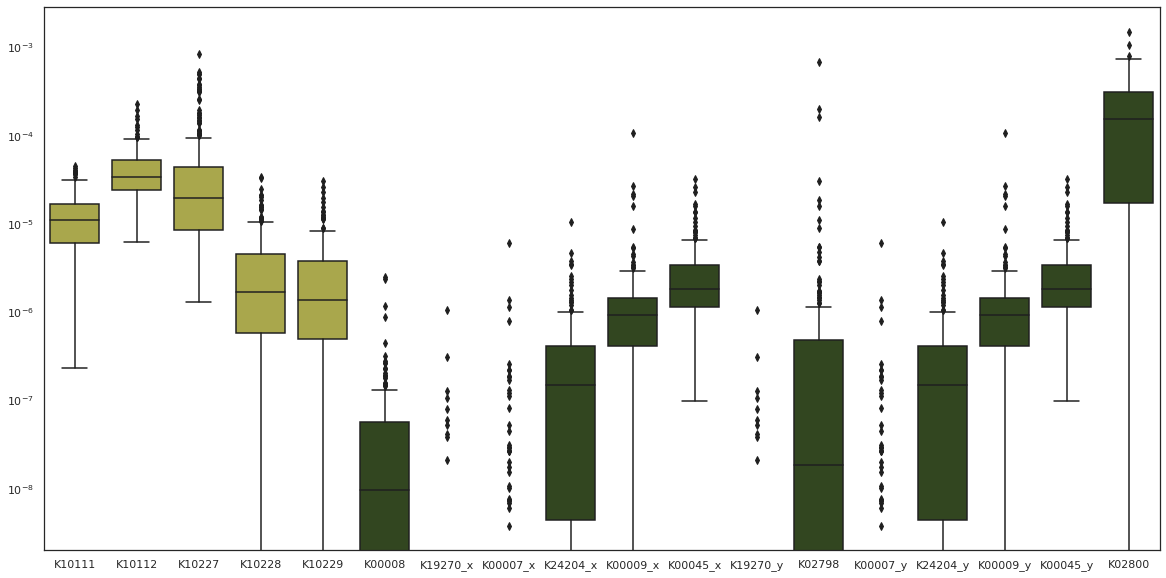

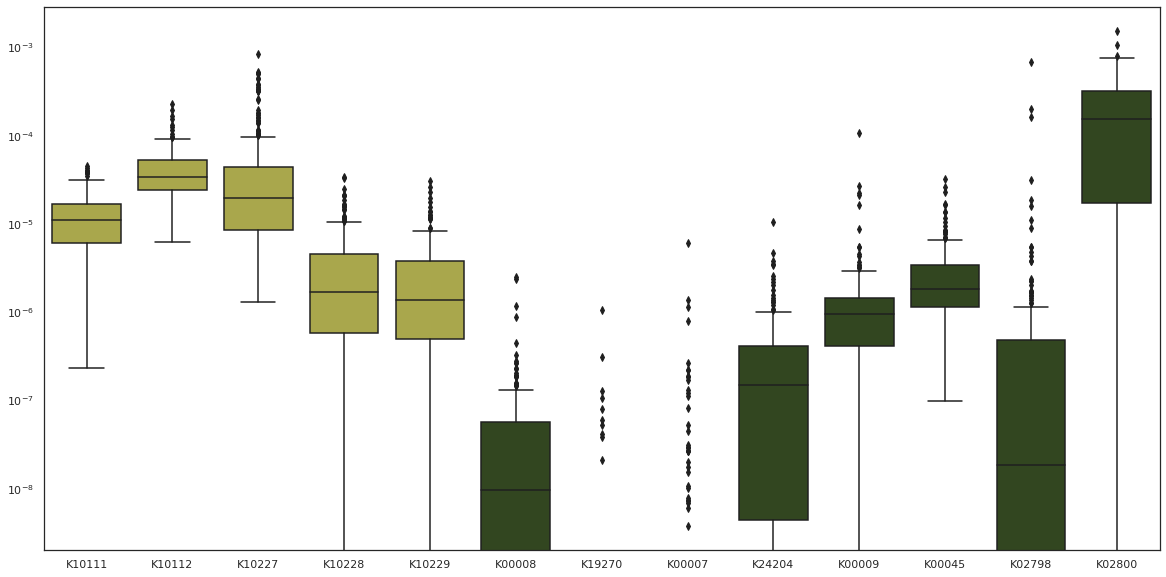

In [37]:
M_combo, M_cdict = create_box_plot(Tbact_summed, compound='Mannitol', colors = ['#B8B63D','#314D19'])
# plt.savefig('figures/tara/Bact_Manitol_distributions.pdf')
fig, ax = plt.subplots(1)
all_cdict={}
for key in M_cdict.keys():
    nk = key.strip('_x').strip('_y') 
    all_cdict[nk] = M_cdict[key]
for key in GB_cdict.keys():
    all_cdict[key]=GB_cdict[key]
    
for M in  M_combo.columns:
    if M.endswith('_y'):
        M_combo = M_combo.drop(M, axis=1)    
cols =[ M.strip('_x') for M in M_combo]
M_combo.columns = cols

M_set = set(key.strip('_x').strip('_y') for key in M_cdict.keys())
GB_set = set(GB_cdict.keys())

g = sns.boxplot(data = M_combo,palette=all_cdict)
g.set_yscale('log')
plt.savefig('figures/tara/Bact_Manitol_distributions.pdf')

### Run correlation analysis for Mannitol and GB for all summed abundances across Tara bacterial metaT; comparison to environmental data

In [18]:
MGB_combo = M_combo.merge(GB_combo, left_index=True, right_index=True)
MGB_combo = MGB_combo.drop(['K11440','K17755'], axis=1)
MGB_bact_rho, MGB_bact_pval, MGB_bact_bonfe= calc_rho_pval(MGB_combo)

# MGB_combo_corr = MGB_combo.corr('spearman')
# MGB_combo_corr = MGB_combo_corr.dropna(axis=1, how='all').dropna(axis=0, how='all')
row_colors = MGB_bact_rho.index.map(all_cdict)
pass_val  = MGB_combo.columns[MGB_combo.mean()>10e-7]



In [38]:
MGB_bact_rho.to_csv('MGB_bact_rho.csv')

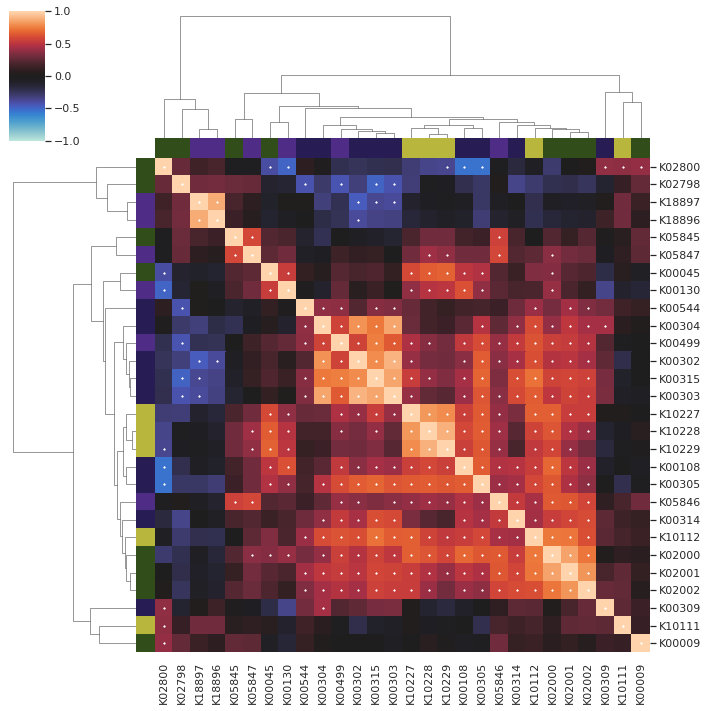

In [19]:
cluster_map_bonfe(MGB_bact_rho.loc[pass_val, pass_val], MGB_bact_bonfe.loc[pass_val, pass_val], cutoff=0.001, figname='figures/tara/Tbact_cluster_bonfe.pdf', 
                  col_colors=row_colors, row_colors=row_colors)

In [20]:
MGB_env_params = env_params.merge(MGB_combo, left_index=True, right_index=True, how='inner')
cols = ['Temperature (°C)', 'Salinity (PSU)',
       'Density (kg/m**3)', 'Distance_coast (km)', 'Chlorophyll_A (mg/m**3)',
       'PAR (mol quanta/m**2/day)', 'O2 (µmol/kg)', 'NO3 (µmol/l)',
       'Iron_5m* (µmol/l)', 'Ammonium_5m* (µmol/l)', 'Nitrite_5m* (µmol/l)',
       'Nitrate_5m* (µmol/l)', 'CDOM* (ppb (QSE))', 'NPP_C* (mg/m**2/day)',
       'POC* (µg/kg)', 'PIC* (mol/m3)', 'Alkalinity (µmol/kg)',
       'Carbon Total (µmol/kg)', 'CO2 (µmol/kg)', 'CO3 (µmol/kg)',
       'HCO3 (µmol/kg)', 'pH (-)', 'NO2 (µmol/l)', 'PO4 (µmol/l)',
       'NO3_NO2 (µmol/l)', 'Si (µmol/l)', 'MLD (m)', 'DCM (m)',
       'Depth_max_Brunt_Väisälä_freq (m)', 'Depth_max_O2 (m)',
       'Depth_min_O2 (m)', 'Depth_nitracline (m)', 'Shannon_Darwin* (-)',
       'Shannon_Physat* (-)', 'miTAG_SILVA_Chao (-)',
       'miTAG_SILVA_Shannon (-)', 'OG_Richness (-)', 'OG_Evenness (-)',
       'Chlorophyll c3 (mg/m**3)', 'Peridinin (mg/m**3)',
       'Fucoxanthin (mg/m**3)', 'Prasinoxanthin (mg/m**3)',
       '19-Hexanoyloxyfucoxanthin (mg/m**3)', 'Alloxanthin (mg/m**3)',
       'Zeaxanthin (mg/m**3)', 'Lutein (mg/m**3)', 'Latitude (-)',
       'Longitude (-)', 'Sea_ice* (%)', 'Okubo-Weiss* (-)',
       'Lyapunov* (l/day)', 'Residence_time* (days)',]

MGB_bact_env_rho, MGB_bact_env_pval, MGB_bact_env_bonfe = calc_rho_pval(MGB_env_params)

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

In [21]:

MGB_bact_env_rho = MGB_bact_env_rho.loc[cols,pass_val]
MGB_bact_env_pval = MGB_bact_env_pval.loc[cols,pass_val]
MGB_bact_env_bonfe = MGB_bact_env_bonfe.loc[cols,pass_val]
MGB_bact_env_bonfe = cal_bonfe(MGB_bact_env_pval,pass_val, cols)


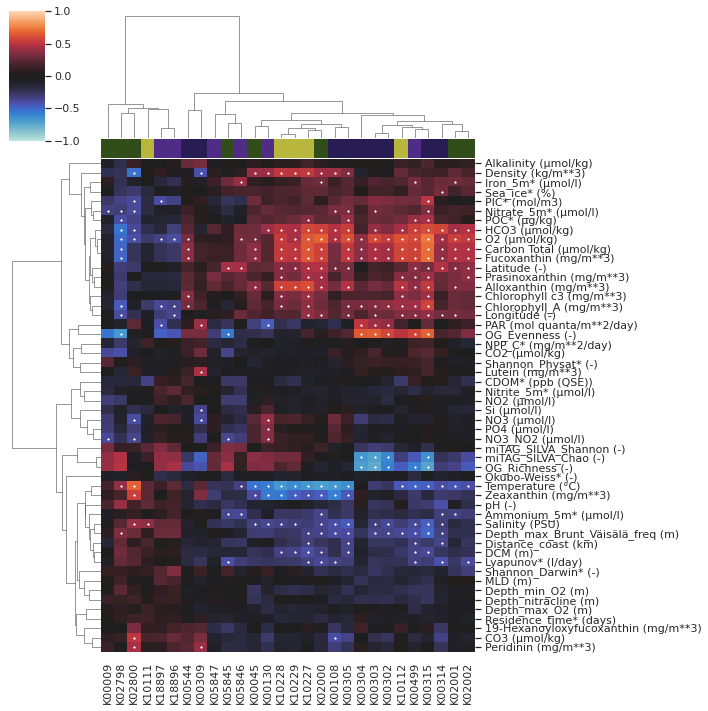

In [22]:
cluster_map_bonfe(MGB_bact_env_rho, MGB_bact_env_bonfe, cutoff=0.001, 
                  figname='figures/tara/Tbact_cluster_env_bonfe.pdf', col_colors=row_colors)


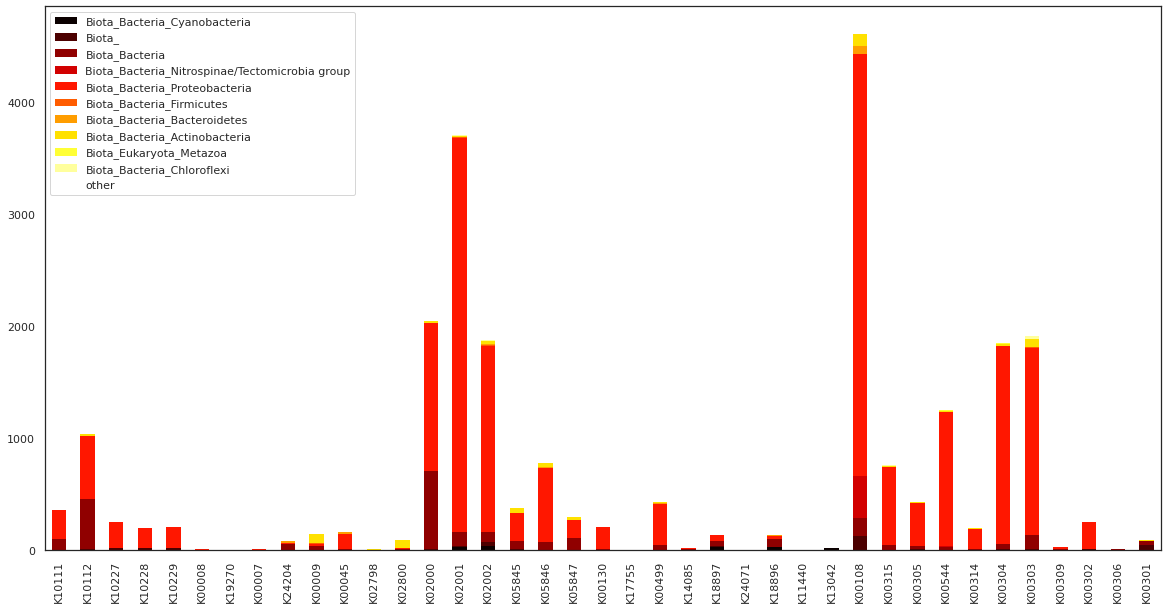

In [23]:
all_groups =[]
for K in all_cdict.keys():
    t = subset_abund[K]['Tbact']
    t['sub_taxa'] = t.taxonomy.str.split('; ').str[0:3].str.join('_')
    groups = t.groupby('sub_taxa').count().index
#     taxonomy.loc[groups, K]=t.groupby('sub_taxa').count()['taxonomy']
    all_groups.append(list(groups))
allgroup_flat = [item for sublist in all_groups for item in sublist]
taxonomy=pd.DataFrame(columns = all_cdict.keys(), index=set(allgroup_flat))
for K in all_cdict.keys():
    t = subset_abund[K]['Tbact']
    t['sub_taxa'] = t.taxonomy.str.split('; ').str[0:3].str.join('_')
    flat_list = [item for sublist in t for item in sublist]
    taxonomy[K] = t.groupby('sub_taxa').count()
taxonomy = taxonomy.fillna(0)
taxonomy2 = taxonomy
to_drop = taxonomy[taxonomy.sum(axis=1)<20].index
taxonomy.loc['other'] = taxonomy.loc[to_drop].sum()
taxonomy = taxonomy.drop(to_drop)
taxonomy.T.plot(kind='bar', stacked=True, lw=0, cmap=sns.color_palette('hot', as_cmap=True))
taxonomy_norm = taxonomy/taxonomy.sum()
plt.savefig('figures/tara/Bact_TotalTranscripts_recovered_metaT.pdf')
# Only plot things that are greater than a cutoff
passing_set = taxonomy.T.loc[taxonomy.sum(axis=0)>100].T.columns

<Figure size 864x576 with 0 Axes>

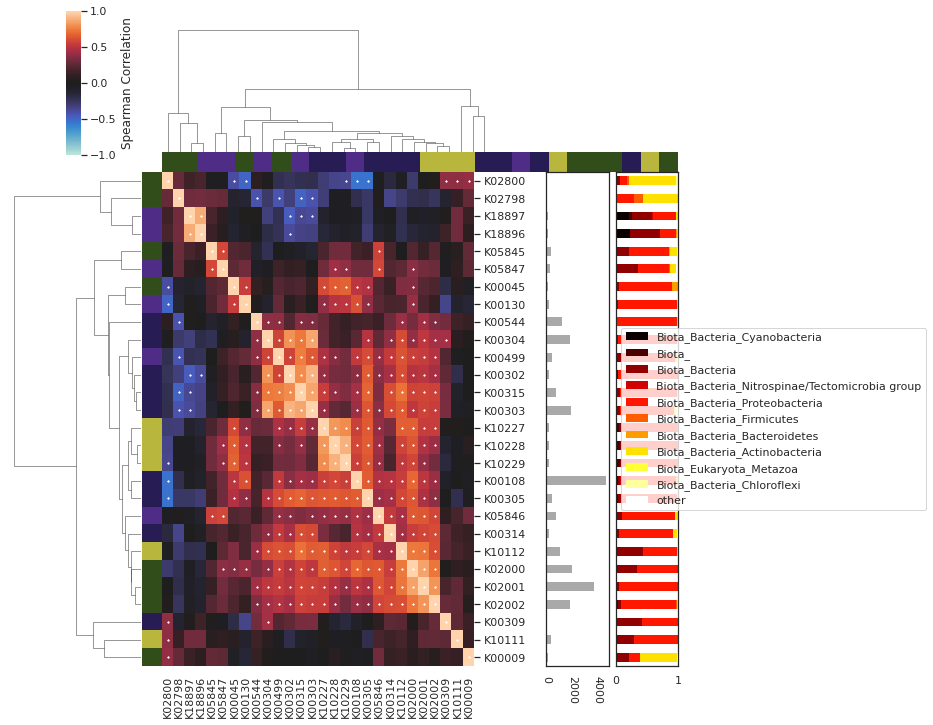

In [24]:
fig = plt.figure(figsize=[12,8])

cluster = sns.clustermap(MGB_bact_rho.loc[pass_val, pass_val].fillna(0), col_colors=row_colors, row_colors=row_colors,yticklabels=1, 
                         metric='braycurtis',
                 vmin=-1, vmax=1, cmap=sns.color_palette("icefire", as_cmap=True),
                  xticklabels =1,)
posx_dict={}
for i in np.array(cluster.ax_heatmap.get_xticklabels()):
    posx_dict[i.get_text()] = i.get_position()[0]
posy_dict={}
for i in np.array(cluster.ax_heatmap.get_yticklabels()):
    posy_dict[i.get_text()] = i.get_position()[1]

sig_map = MGB_bact_bonfe.loc[pass_val, pass_val]
sig_map = sig_map<0.001
sig_map.index = sig_map.index.map(posy_dict)
sig_map.columns = sig_map.columns.map(posx_dict)
x =[]
y = []
for i in sig_map.index:
    for c in sig_map.columns:
        if sig_map.loc[i,c]==True:
            x.append(c)
            y.append(i)


axT = cluster.ax_heatmap
axT.scatter(x,y, marker='*', color='white', s=2)


cluster.gs.update(right=0.95)
# divide existing axes
divider = make_axes_locatable(cluster.ax_heatmap)
divider2 = make_axes_locatable(cluster.ax_col_dendrogram)
# create new axes for bar plot 
ax = divider.append_axes("right", size="20%", pad=1)
ax2 = divider.append_axes("right", size="20%", pad=0.1)

# create empty space of same size as bar plot axes (don't use this space)
nax = divider2.new_horizontal(size="20%", pad=1.7)

target = [t.get_text() for t in np.array(cluster.ax_heatmap.get_yticklabels())]
ind= np.array([list(MGB_bact_rho.index.values).index(t) for t in target])
# # plot bar plot in ax
taxonomy_norm[target[::-1]].T.plot(kind='barh', ax = ax2, stacked=True,lw=0, cmap=sns.color_palette('hot', as_cmap=True) )
taxonomy[target[::-1]].sum().plot(kind='barh', ax = ax, color='darkgrey', lw=0,)
ax.set_yticklabels('')
ax2.set_yticklabels('')
ax.set_xticks([0,2000,4000])
ax.set_xticklabels([0,2000,4000], rotation=270)
ax2.set_xlim([0,1])
plt.rcParams['xtick.bottom'] = True
# ax.barh(np.arange(len(target)), taxonomy.values[ind], color='k')
# ax.set_yticklabels([])
# ax.set_ylim(-0.5,len(grouped_MMETSP.index)-.5)
# ax.invert_yaxis()
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('top')
# if genome:
#     ax.set_xlabel('Total Genomes')
# else:
#     ax.set_xlabel('Total Transcriptomes')
# ax.xaxis.set_label_position('top') 
cluster.cax.set_position([0.1, .8, .02, 0.2])
cluster.cax.set_ylabel('Spearman Correlation')




plt.savefig('figures/tara/Tbact_bar_clustermap.pdf')

### plot manitol and Glycine Betaine distribution maps for metaT

()

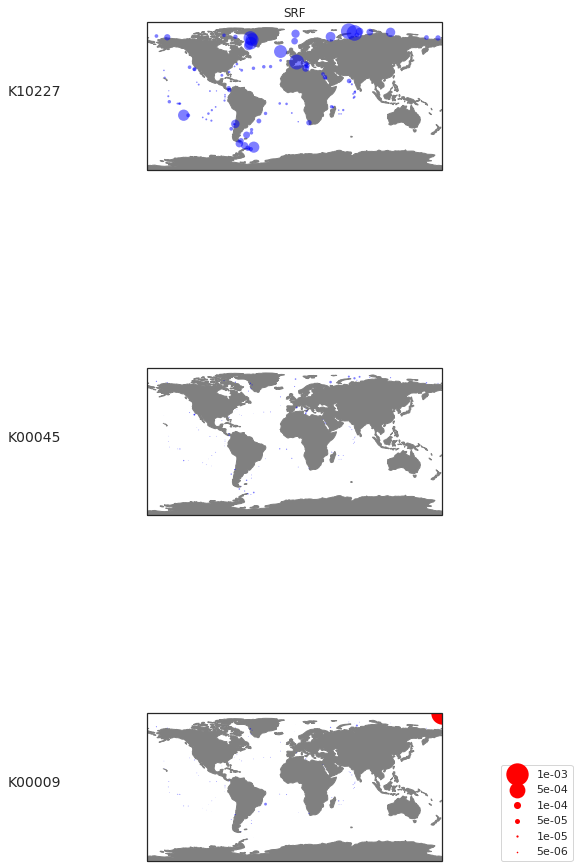

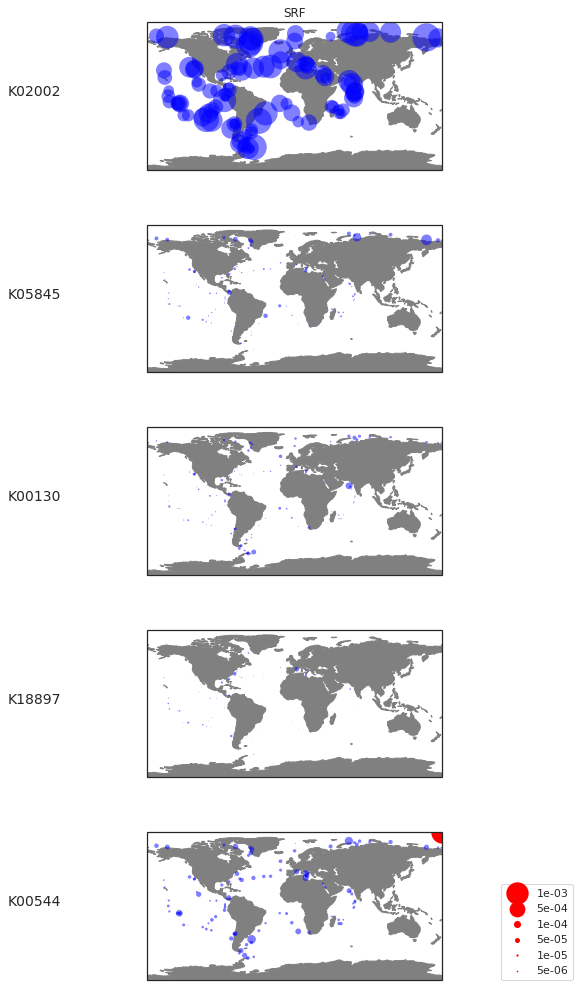

In [25]:
def Kplot_maps_subplot(Tbact_summed_env, Klist=['K00130'], kname='test', scale = 10e5, color='blue', depth_list = ['SRF', 'DCM', 'MES']):
    fig = plt.figure(figsize=(18, 18))
    gs = fig.add_gridspec(len(Klist), 3)
    for i, k in enumerate(Klist):
        for j,d in enumerate(depth_list):
            subset = Tbact_summed_env[Tbact_summed_env['depth']==d]
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
#             ax.coastlines()
            ax.add_feature(cfeature.LAND, color = 'gray')
            ax.scatter(x =subset.longitude, y=subset.latitude, 
               s= subset[k]*scale, transform=ccrs.PlateCarree(), alpha=0.5,color=color, lw=0)
            ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            if j == 0:
                ax.text(-350,1, k, fontsize=14)

            if i ==0:
                ax.set_title(d)
    legend_sizes = [1e-3, 5e-4, 1e-4, 5e-5,1e-5,5e-6]
    for i in legend_sizes:
        ax.scatter(x=180, y=90, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
    ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)
    plt.savefig(kname+'_Tbact.pdf')
    return()

Kplot_maps_subplot(Tbact_summed_env, Klist=['K10227','K00045', 'K00009'], kname='figures/tara/mannitol_bact', 
                   scale=5e5, depth_list = ['SRF'])

Kplot_maps_subplot(Tbact_summed_env, Klist=['K02002','K05845','K00130','K18897','K00544'], kname='figures/tara/gb_bact', 
                   scale=5e5, 
                   depth_list = ['SRF'])


## Plotting Manitol and Glycine Betain for Euks (as above) focused on metaT

Index(['K00130', 'K17755', 'K00499', 'K14085', 'K18897', 'K24071', 'K18896',
       'K11440', 'K13042', 'K00108', 'K00315', 'K00544', 'K00314', 'K00304',
       'K00303', 'K00309', 'K00302', 'K00306', 'K00301'],
      dtype='object')
Index(['K00008', 'K19270_x', 'K00007_x', 'K24204_x', 'K00009_x', 'K00045_x',
       'K19270_y', 'K02798', 'K00007_y', 'K24204_y', 'K00009_y', 'K00045_y',
       'K02800'],
      dtype='object')


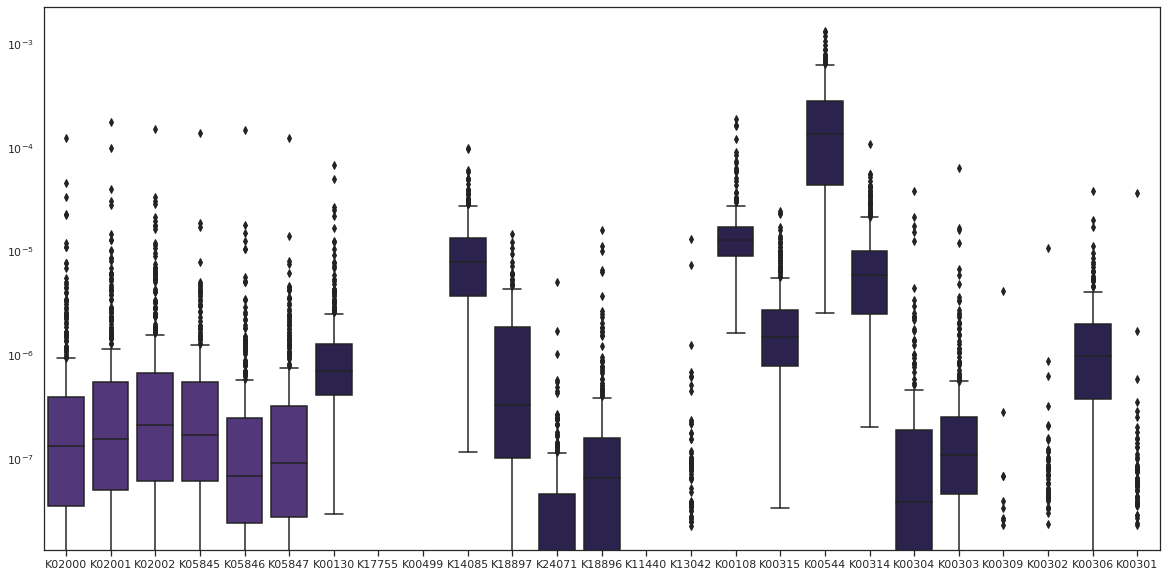

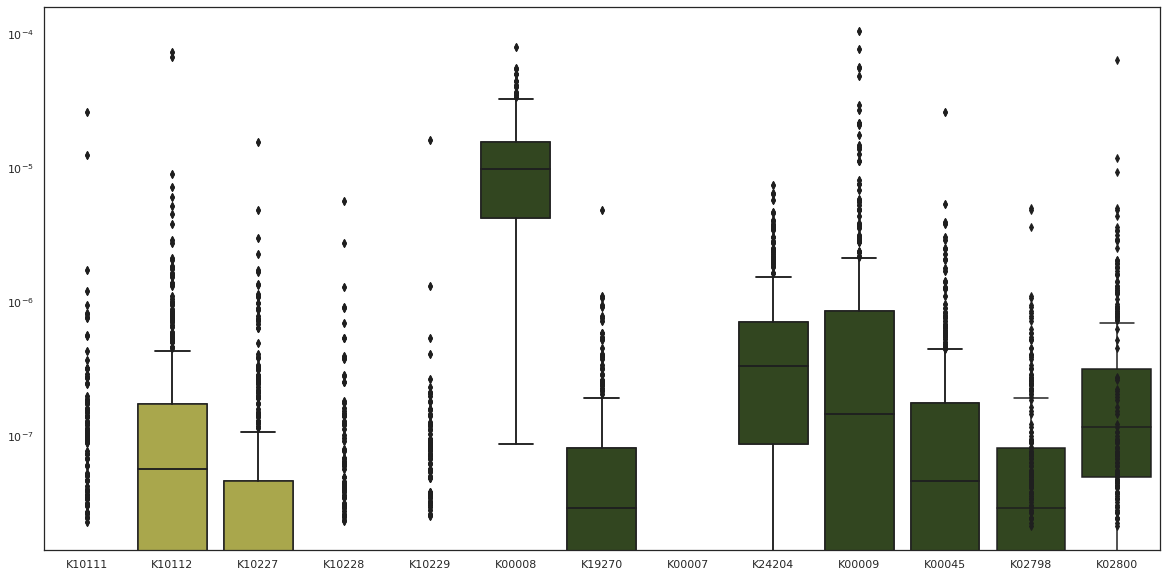

In [26]:
fig, ax = plt.subplots(1)
GB_combo, GB_cdict = create_box_plot(Teuk_summed, compound='Glycine betaine', colors  = ['#4F2D86','#271C54'])
plt.savefig('figures/tara/Euk-Glycine_betaine_distributions.pdf')

fig, ax = plt.subplots(1)

M_combo, M_cdict = create_box_plot(Teuk_summed, compound='Mannitol', colors = ['#B8B63D','#314D19'])
plt.savefig('figures/tara/Euk_Manitol_distributions.pdf')
all_cdict={}
for key in M_cdict.keys():
    nk = key.strip('_x').strip('_y') 
    all_cdict[nk] = M_cdict[key]
for key in GB_cdict.keys():
    all_cdict[key]=GB_cdict[key]
    
for M in  M_combo.columns:
    if M.endswith('_y'):
        
        M_combo = M_combo.drop(M, axis=1)
        
cols =[ M.strip('_x') for M in M_combo]
M_combo.columns = cols
M_set = set(key.strip('_x').strip('_y') for key in M_cdict.keys())
GB_set = set(GB_cdict.keys())
g = sns.boxplot(data = M_combo,palette=all_cdict)
g.set_yscale('log')
plt.savefig('figures/Euk_Manitol_distributions.pdf')

MGB_combo_euk = M_combo.merge(GB_combo, left_index=True, right_index=True)


In [27]:
KOs = MGB_combo_euk.T[MGB_combo_euk.sum()>0].index
MGB_combo_euk = MGB_combo_euk[KOs]

MGB_euk_env_params = env_params.merge(MGB_combo_euk, left_index=True, right_index=True, how='inner')
cols = ['Temperature (°C)', 'Salinity (PSU)',
       'Density (kg/m**3)', 'Distance_coast (km)', 'Chlorophyll_A (mg/m**3)',
       'PAR (mol quanta/m**2/day)', 'O2 (µmol/kg)', 'NO3 (µmol/l)',
       'Iron_5m* (µmol/l)', 'Ammonium_5m* (µmol/l)', 'Nitrite_5m* (µmol/l)',
       'Nitrate_5m* (µmol/l)', 'CDOM* (ppb (QSE))', 'NPP_C* (mg/m**2/day)',
       'POC* (µg/kg)', 'PIC* (mol/m3)', 'Alkalinity (µmol/kg)',
       'Carbon Total (µmol/kg)', 'CO2 (µmol/kg)', 'CO3 (µmol/kg)',
       'HCO3 (µmol/kg)', 'pH (-)', 'NO2 (µmol/l)', 'PO4 (µmol/l)',
       'NO3_NO2 (µmol/l)', 'Si (µmol/l)', 'MLD (m)', 'DCM (m)',
       'Depth_max_Brunt_Väisälä_freq (m)', 'Depth_max_O2 (m)',
       'Depth_min_O2 (m)', 'Depth_nitracline (m)', 'Shannon_Darwin* (-)',
       'Shannon_Physat* (-)', 'miTAG_SILVA_Chao (-)',
       'miTAG_SILVA_Shannon (-)', 'OG_Richness (-)', 'OG_Evenness (-)',
       'Chlorophyll c3 (mg/m**3)', 'Peridinin (mg/m**3)',
       'Fucoxanthin (mg/m**3)', 'Prasinoxanthin (mg/m**3)',
       '19-Hexanoyloxyfucoxanthin (mg/m**3)', 'Alloxanthin (mg/m**3)',
       'Zeaxanthin (mg/m**3)', 'Lutein (mg/m**3)', 'Latitude (-)',
       'Longitude (-)', 'Sea_ice* (%)', 'Okubo-Weiss* (-)',
       'Lyapunov* (l/day)', 'Residence_time* (days)',]


MGB_euk_rho, MGB_euk_pval, MGB_euk_bonfe, = calc_rho_pval(MGB_combo_euk, )
pass_val  = MGB_combo_euk.columns[MGB_combo_euk.mean()>10e-8]


In [39]:
MGB_euk_rho.to_csv('MGB_euk_rho.csv')

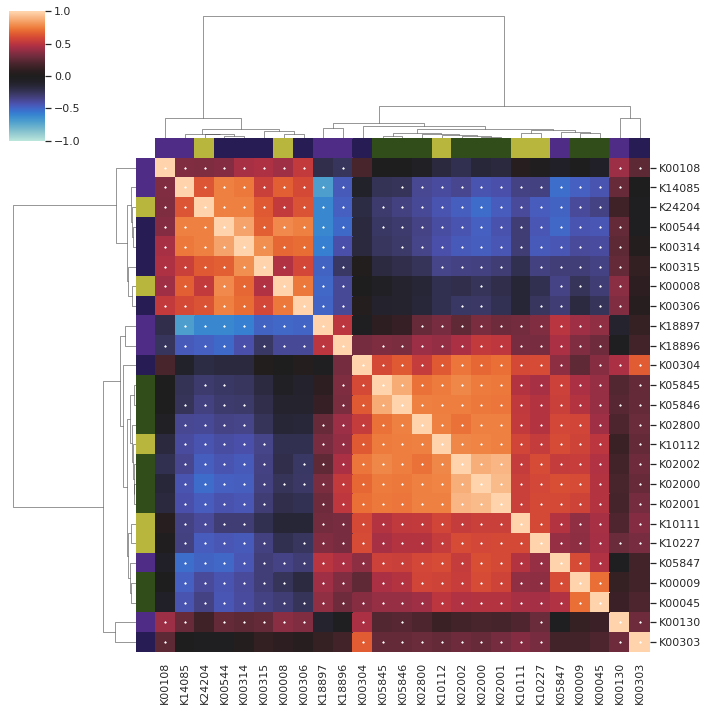

In [29]:
cluster_map_bonfe(MGB_euk_rho.loc[pass_val, pass_val], MGB_euk_bonfe.loc[pass_val, pass_val], row_colors=row_colors, col_colors=row_colors, cutoff=0.001, 
                  figname='figures/tara/Teuk_cluster_bonfe.pdf',)


In [30]:

MGB_euk_env_rho, MGB_euk_env_pval, MGB_euk_env_bonfe = calc_rho_pval(MGB_euk_env_params)
MGB_euk_env_rho = MGB_euk_env_rho.loc[cols,pass_val]
MGB_euk_env_pval = MGB_euk_env_pval.loc[cols,pass_val]
MGB_euk_env_bonfe = MGB_euk_env_bonfe.loc[cols,pass_val]
MGB_euk_env_bonfe = cal_bonfe(MGB_euk_env_pval,pass_val, cols)


/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
 

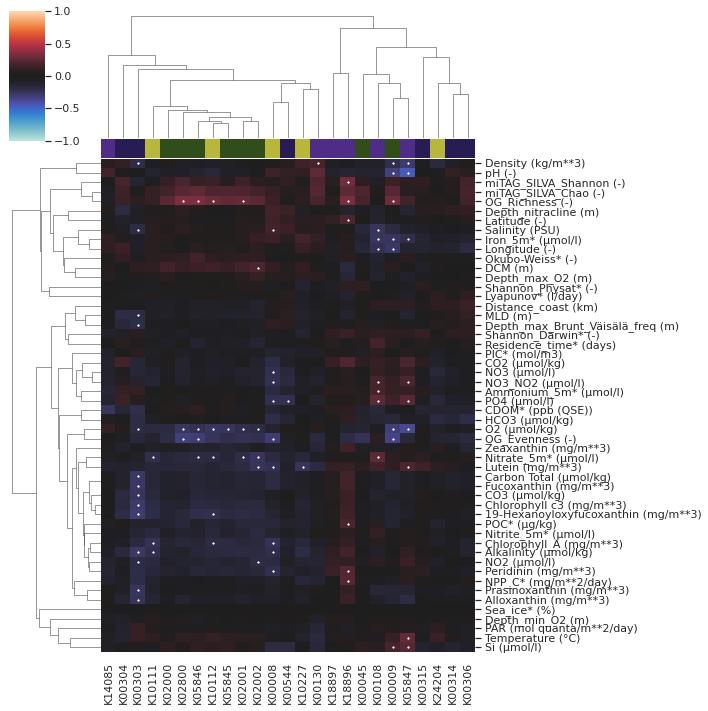

In [31]:
cluster_map_bonfe(MGB_euk_env_rho, MGB_euk_env_bonfe, cutoff=0.001, 
                  figname='figures/tara/Teuk_cluster_env_bonfe.pdf', col_colors=row_colors)


()

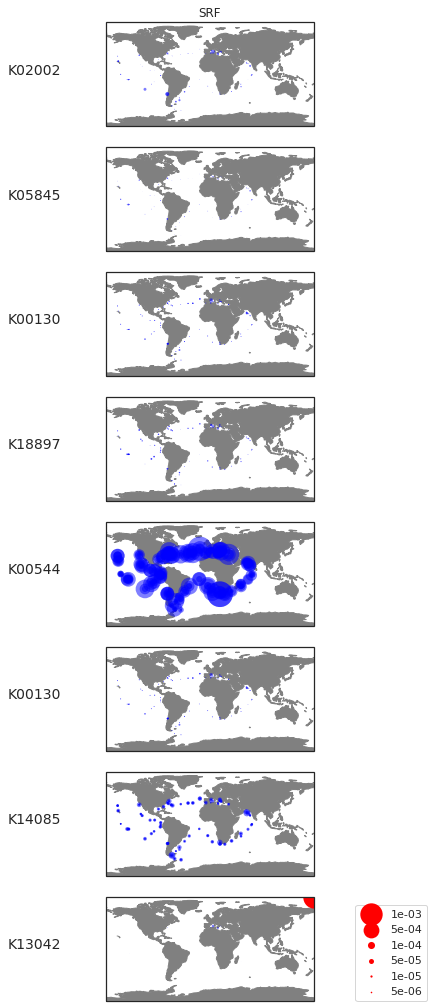

In [32]:
# Kplot_maps_subplot(Teuk_summed_env, Klist=['K10227','K00045', 'K00009'], kname='figures/euk_mannitol', 
#                    scale=5e5, depth_list = ['SRF'])

Kplot_maps_subplot(Teuk_summed_env, Klist=['K02002','K05845','K00130','K18897','K00544', 'K00130',
                                          'K14085', 'K13042'], kname='figures/tara/euk_gb', 
                   scale=5e5, 
                   depth_list = ['SRF'])


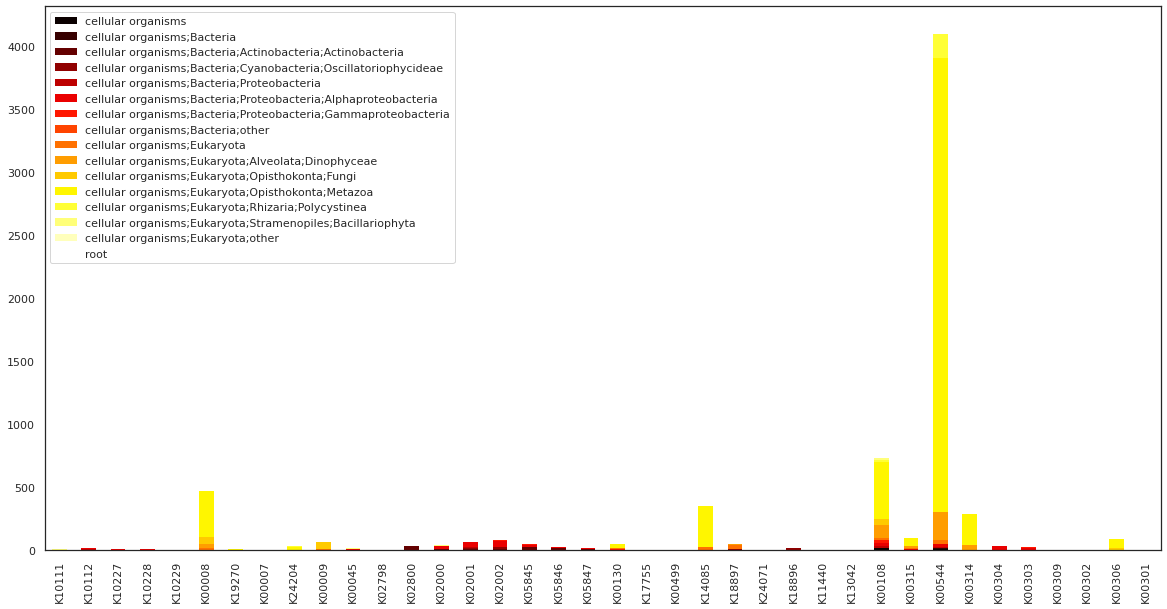

In [33]:
all_groups =[]
for K in all_cdict.keys():
    t = subset_abund[K]['Teuk']
    if 'taxonomy' not in t.columns:
        pass
    else:
        
        t['sub_taxa'] = t.taxonomy.str.split('; ').str[1:5].str.join(';')
        groups = t.groupby('sub_taxa').count().index
    #     taxonomy.loc[groups, K]=t.groupby('sub_taxa').count()['taxonomy']
        all_groups.append(list(groups))
allgroup_flat = [item for sublist in all_groups for item in sublist]
# print(allgroup_flat)
euk_taxonomy=pd.DataFrame(columns = all_cdict.keys(), index=set(allgroup_flat))
for K in all_cdict.keys():
    t = subset_abund[K]['Teuk']
    if 'taxonomy' not in t.columns:
        pass
    else:
        t['sub_taxa'] = t.taxonomy.str.split('; ').str[1:5].str.join(';')
        flat_list = [item for sublist in t for item in sublist]
        euk_taxonomy[K] = t.groupby('sub_taxa').count()
euk_taxonomy = euk_taxonomy.fillna(0)


euk_inds = []
bact_inds = []

for i in euk_taxonomy.index:
    if 'Eukaryota' in i:
        euk_inds.append(i)
    elif 'Bacteria' in i:
        bact_inds.append(i)

keep_euk = euk_taxonomy.index[euk_taxonomy.sum(axis=1)>=30]
drop_euk = euk_taxonomy.index[euk_taxonomy.sum(axis=1)<30]

merge_euk = drop_euk.intersection(euk_inds)
merge_bact = drop_euk.intersection(bact_inds)

for ii, n in zip([merge_euk, merge_bact], ['cellular organisms;Eukaryota;other','cellular organisms;Bacteria;other',  ]): 
    euk_taxonomy.loc[n]=euk_taxonomy.loc[ii].sum(axis=1)
    euk_taxonomy = euk_taxonomy.drop(ii)
    
euk_taxonomy = euk_taxonomy.sort_index()
euk_taxonomy.T.plot(kind='bar', stacked=True, lw=0, cmap=sns.color_palette('hot', as_cmap = True))
euk_taxonomy_norm = euk_taxonomy/euk_taxonomy.sum()
plt.savefig('figures/tara/Euk_taxonomy_metaT.pdf')

In [34]:
t = subset_abund['K14085']['Teuk']
s = subset_abund['K00544']['Teuk']
v = subset_abund['K00108']['Teuk']
all_tax=set()
# for a in [t,s,v]:
#     a['grouping'] = a.taxonomy.str.split('; ').str[2:5].str.join(';').fillna('-')
#     all_tax = all_tax.union(a.groupby('grouping').count()['taxonomy'].index)

# merged_tax = pd.DataFrame(index=all_tax)
# for a, k in zip([t,s,v], ['K14085','K00544','K00108']):
#     a['grouping'] = a.taxonomy.str.split('; ').str[2:5].str.join(';').fillna('-')
#     merged_tax.loc[a.groupby('grouping').count()['taxonomy'].index, k] = a.groupby('grouping').count()['taxonomy']


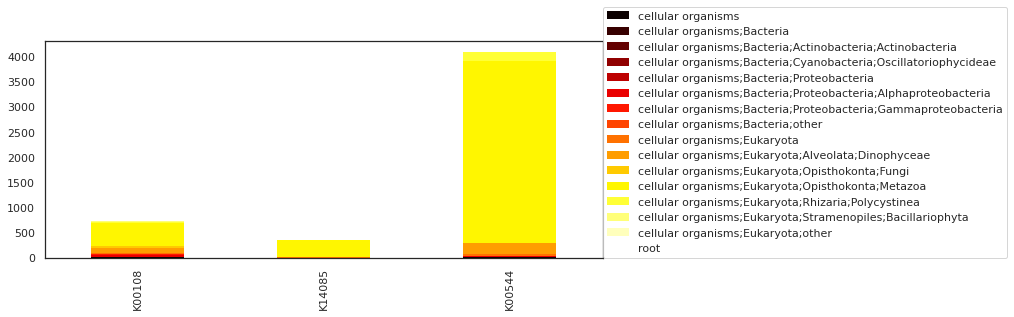

In [35]:
fig,ax = plt.subplots(1, figsize = [10,4])
merged_tax = euk_taxonomy.sort_index()
merged_tax = merged_tax[['K00108','K14085','K00544']]
merged_tax.T.plot(kind='bar', stacked=True, cmap = sns.color_palette('hot', as_cmap=True,), lw=0, ax = ax)
ax.legend(loc=[1,0])
fig.savefig('figures/tara/GB_Euk_synbd_tax.pdf')

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


()

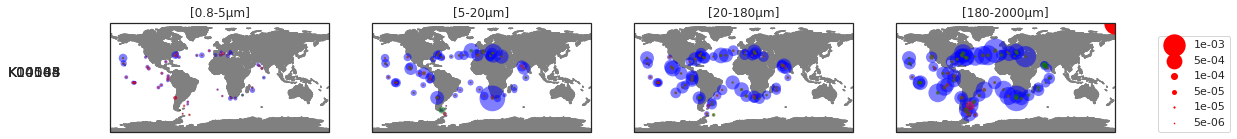

In [36]:
def Kplot_maps_subplot_euk_overlay(Tbact_summed_env, Klist=['K00130'], kname='test', scale = 10e5, colors=['blue', ], depth_list = ['[0.8-5µm]', '[5-20µm]', '[20-180µm]', '[180-2000µm]',]):
    fig = plt.figure(figsize=(18, 18))
    gs = fig.add_gridspec(1, 4)
    for i, k in enumerate(Klist):
        subset_big = Tbact_summed_env[Tbact_summed_env['depth']=='SRF']
        for j,d in enumerate(depth_list):
            
            subset = subset_big[subset_big['size fraction']==d]
            ax = fig.add_subplot(gs[0, j], projection=ccrs.PlateCarree())
#             ax.coastlines()
            ax.add_feature(cfeature.LAND, color = 'gray')
            ax.scatter(x =subset.longitude, y=subset.latitude, 
               s= subset[k]*scale, transform=ccrs.PlateCarree(), alpha=0.5,color=colors[i], lw=0)
            ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            if j == 0:
                ax.text(-350,1, k, fontsize=14)

            if i ==0:
                ax.set_title(d)
    legend_sizes = [1e-3, 5e-4, 1e-4, 5e-5,1e-5,5e-6]
    for i in legend_sizes:
        ax.scatter(x=180, y=90, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
    ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)
    plt.savefig(kname+'_Teuk.pdf')
    return()
Kplot_maps_subplot_euk_overlay(Teuk_summed_env, Klist=['K00544','K00108','K14085'], kname='figures/tara/euk_gb_synbd', 
                   scale=5e5, colors=['blue','red','green'])

In [59]:
i=['K00315', 'K00302', 'K00303', 'K00304',  ]
MGB_bact_rho.loc[i,i]


,K00315,K00302,K00303,K00304
K00315,1,0.789713,0.86647,0.736828
K00302,0.789713,1,0.902077,0.811691
K00303,0.86647,0.902077,1,0.865719
K00304,0.736828,0.811691,0.865719,1


In [60]:
MGB_bact_bonfe.loc[i,i]

level_0,K00315,K00302,K00303,K00304
level_1,,,,
K00315,0,5.59591e-38,1.41641e-54,3.84156e-30
K00302,5.59591e-38,0,2.71536e-66,6.19376e-42
K00303,1.41641e-54,2.71536e-66,0,2.29391e-54
K00304,3.84156e-30,6.19376e-42,2.29391e-54,0


In [67]:
MGB_euk_env_rho['K18896']

Temperature (°C)                       0.0461674
Salinity (PSU)                         0.0185276
Density (kg/m**3)                     -0.0402675
Distance_coast (km)                   -0.0632555
Chlorophyll_A (mg/m**3)                 0.116574
PAR (mol quanta/m**2/day)             -0.0661525
O2 (µmol/kg)                           -0.110454
NO3 (µmol/l)                           0.0692266
Iron_5m* (µmol/l)                      0.0532035
Ammonium_5m* (µmol/l)                  0.0662467
Nitrite_5m* (µmol/l)                   0.0847282
Nitrate_5m* (µmol/l)                   0.0260058
CDOM* (ppb (QSE))                      0.0910158
NPP_C* (mg/m**2/day)                    0.229153
POC* (µg/kg)                            0.201881
PIC* (mol/m3)                          0.0287941
Alkalinity (µmol/kg)                    0.166143
Carbon Total (µmol/kg)                  0.175408
CO2 (µmol/kg)                           0.213333
CO3 (µmol/kg)                           0.138117
HCO3 (µmol/kg)      